In [1]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"harshithsai82","key":"d84c8f9073b8eba61e17b6404c056ce8"}'}

In [2]:
!pip install kaggle


In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
A

In [4]:
# Download the "Finding Lungs in CT Data" dataset
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

# Unzip the dataset
# It contains multiple zip files inside, so we'll unzip the main one first
!unzip -q finding-lungs-in-ct-data.zip

# Create directories for images and masks
!mkdir -p data/images
!mkdir -p data/masks

# Now unzip the images and masks into the 'data' directory
!unzip -q 2d_images.zip -d data/images
!unzip -q 2d_masks.zip -d data/masks
print("Segmentation dataset downloaded and unzipped successfully!")

Dataset URL: https://www.kaggle.com/datasets/kmader/finding-lungs-in-ct-data
License(s): unknown
 93% 978M/1.03G [00:10<00:01, 43.9MB/s]
100% 1.03G/1.03G [00:10<00:00, 103MB/s]
Segmentation dataset downloaded and unzipped successfully!


In [27]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split

# --- CORRECTED PATHS FOR SEGMENTATION DATASET ---
image_dir = 'data/images/'
mask_dir = 'data/masks/'
# ------------------------------------------------

image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])

print(f"Found {len(image_files)} images and {len(mask_files)} masks.")

# Split the file paths into training, validation, and test sets
# 80% for training, 20% for temporary (which we'll split into validation and test)
train_images, temp_images, train_masks, temp_masks = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)

# Split the temporary set into 50% validation and 50% test
val_images, test_images, val_masks, test_masks = train_test_split(
    temp_images, temp_masks, test_size=0.5, random_state=42
)

def read_and_resize(filepaths, size=(256, 256)):
    images = []
    for file in filepaths:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, size)
        img = np.expand_dims(img, axis=-1) # Add channel dimension
        images.append(img)
    return np.array(images, dtype=np.float32) / 255.0 # Normalize to [0, 1] and cast to float32

# Load the actual image data
X_train = read_and_resize(train_images)
Y_train = read_and_resize(train_masks)

X_val = read_and_resize(val_images)
Y_val = read_and_resize(val_masks)

X_test = read_and_resize(test_images)
Y_test = read_and_resize(test_masks)

print("Training data shape:", X_train.shape, Y_train.shape)
print("Validation data shape:", X_val.shape, Y_val.shape)
print("Test data shape:", X_test.shape, Y_test.shape)

Found 267 images and 267 masks.
Training data shape: (213, 256, 256, 1) (213, 256, 256, 1)
Validation data shape: (27, 256, 256, 1) (27, 256, 256, 1)
Test data shape: (27, 256, 256, 1) (27, 256, 256, 1)


In [34]:
# Define data augmentation layers
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

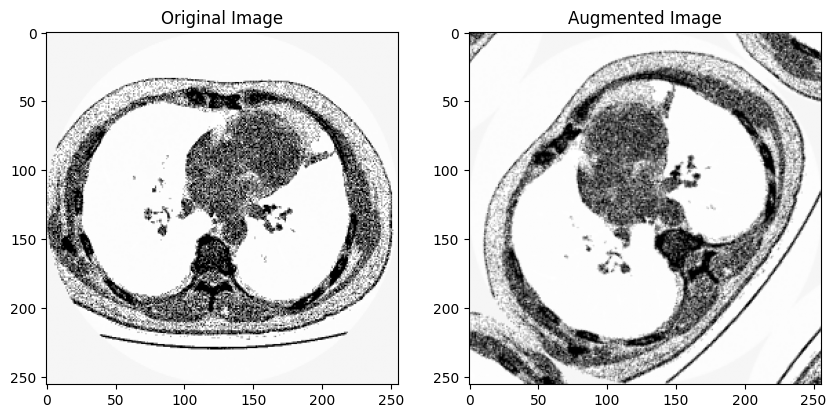

In [35]:
# Assuming 'data_augmentation' is your augmentation layer
# and 'X_train' is your training data
import matplotlib.pyplot as plt

# Apply augmentation to the first image in the training set
augmented_image = data_augmentation(X_train[0:1]) # Must pass a batch

# Plot the original vs. the augmented image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(X_train[0, :, :, 0], cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Augmented Image")
plt.imshow(augmented_image[0, :, :, 0], cmap='gray')
plt.show()

In [28]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import backend as K

# --- Loss Function and Metrics ---
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

# --- U-Net Model Architecture ---
def unet_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)

    u1 = layers.UpSampling2D((2, 2))(c4)
    u1 = layers.Concatenate()([u1, c3])
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)
    c5 = layers.Conv2D(64, 3, activation='relu', padding='same')(c5)

    u2 = layers.UpSampling2D((2, 2))(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)
    c6 = layers.Conv2D(32, 3, activation='relu', padding='same')(c6)

    u3 = layers.UpSampling2D((2, 2))(c6)
    u3 = layers.Concatenate()([u3, c1])
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(u3)
    c7 = layers.Conv2D(16, 3, activation='relu', padding='same')(c7)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c7)

    model = tf.keras.Model(inputs, outputs)
    return model


In [29]:
# Get the input shape from your training data
input_shape = X_train.shape[1:]

# Create the U-Net model
model = unet_model(input_shape)

# Compile the model with the best loss and metrics
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_coef, iou_coef])

# Print the model summary to check the architecture
model.summary()

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=25, # You can increase this for better performance
    batch_size=16,
    validation_data=(X_val, Y_val)
)

print("Model training complete.")

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 256, 256,  │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 256, 256,  │      2,320 │ conv2d_15[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 128, 128,  │          0 │ conv2d_16[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_17 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_3[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 128, 128,  │      9,248 │ conv2d_17[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 32, 32,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 64, 64,    │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 192)              │            │ conv2d_20[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_3[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_23[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 128, 128,  │          0 │ conv2d_24[0][0] 

 Total params: 487,009 (1.86 MB)

 Trainable params: 487,009 (1.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - dice_coef: 0.2896 - iou_coef: 0.1674 - loss: 1.3361 - val_dice_coef: 0.3078 - val_iou_coef: 0.1781 - val_loss: 1.2583
Epoch 2/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - dice_coef: 0.3258 - iou_coef: 0.1919 - loss: 1.1827 - val_dice_coef: 0.4363 - val_iou_coef: 0.2752 - val_loss: 0.9445
Epoch 3/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - dice_coef: 0.4688 - iou_coef: 0.3036 - loss: 0.8882 - val_dice_coef: 0.4129 - val_iou_coef: 0.2566 - val_loss: 1.2237
Epoch 4/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - dice_coef: 0.4662 - iou_coef: 0.3049 - loss: 1.0199 - val_dice_coef: 0.5906 - val_iou_coef: 0.4146 - val_loss: 0.7713
Epoch 5/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 121ms/step - dice_coef: 0.6236 - iou_coef: 0.4488 - loss: 0.6623 - val_dice_coef: 0.6965 - val_iou_coef: 0.5309 - val_loss: 0.6316
Epoch 6/25
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - dice_coef: 0.7220 - iou_coef: 0.5627 - loss: 0.5612 - val_dice_coef: 0.4464 - val_iou_co

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - dice_coef: 0.9650 - iou_coef: 0.9317 - loss: 0.0679
Test Loss: 0.0679
Test Dice Coefficient: 0.9650
Test IoU Score: 0.9317
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step


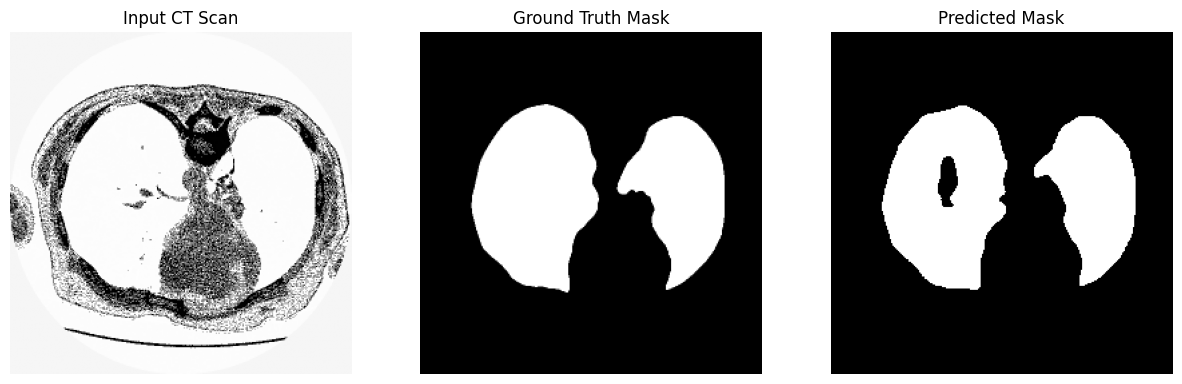

In [30]:
import matplotlib.pyplot as plt

# Evaluate the model on the test set
loss, dice, iou = model.evaluate(X_test, Y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Dice Coefficient: {dice:.4f}")
print(f"Test IoU Score: {iou:.4f}")

# Make predictions
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.uint8)

# Visualize a random sample from the test set
sample_idx = np.random.randint(0, len(Y_test))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(X_test[sample_idx][:, :, 0], cmap='gray')
plt.title("Input CT Scan")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(Y_test[sample_idx][:, :, 0], cmap='gray')
plt.title("Ground Truth Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(Y_pred_bin[sample_idx][:, :, 0], cmap='gray')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


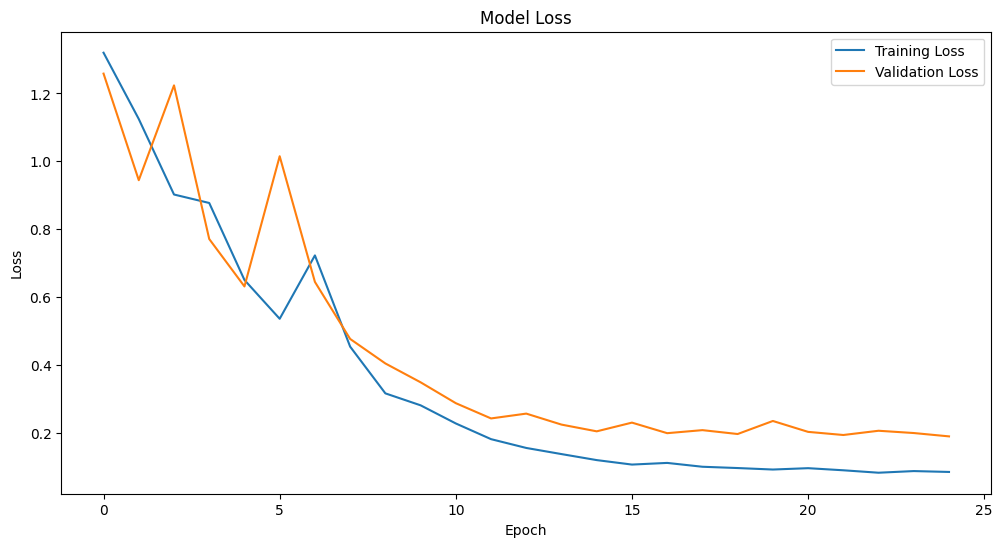

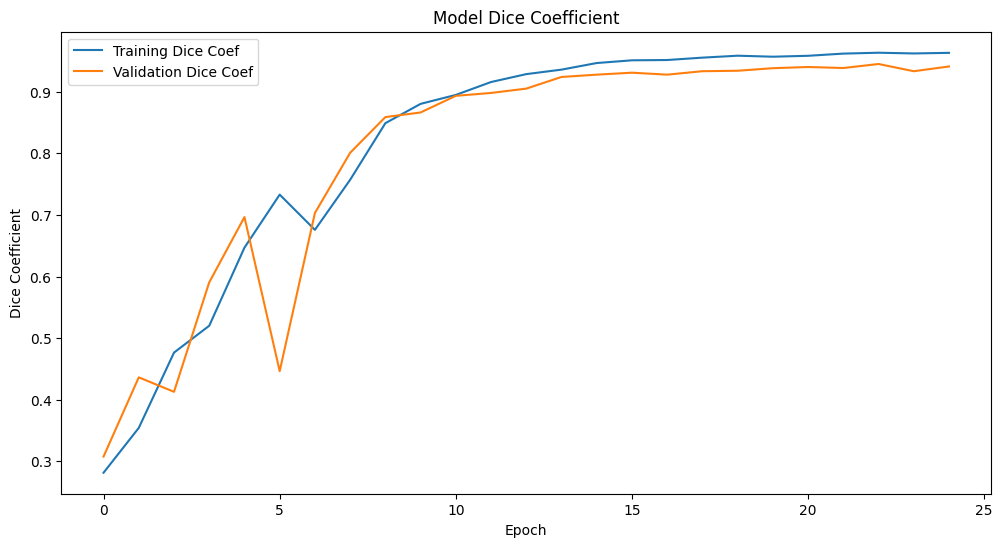

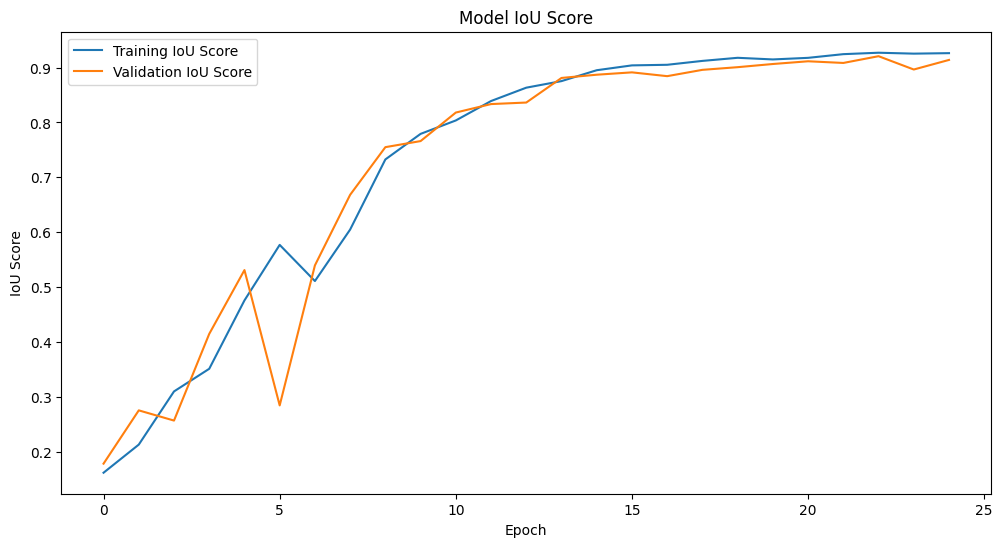

In [36]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('model_loss.png') # Save the plot as a PNG file
plt.show()

# Plot training and validation Dice Coefficient
plt.figure(figsize=(12, 6))
plt.plot(history.history['dice_coef'], label='Training Dice Coef')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coef')
plt.title('Model Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('model_dice_coef.png') # Save the plot as a PNG file
plt.show()

# Plot training and validation IoU Score
plt.figure(figsize=(12, 6))
plt.plot(history.history['iou_coef'], label='Training IoU Score')
plt.plot(history.history['val_iou_coef'], label='Validation IoU Score')
plt.title('Model IoU Score')
plt.xlabel('Epoch')
plt.ylabel('IoU Score')
plt.legend()
plt.savefig('model_iou_score.png') # Save the plot as a PNG file
plt.show()